In [ ]:
import numpy as np

from keras.preprocessing.image import ImageDataGenerator
from keras import layers
from keras import models
from keras import optimizers

import matplotlib.pyplot as plt

In [ ]:
import os, shutil

base_dir = r'E:\hand_gesture_dataset\splited'

train_dir = os.path.join(base_dir, 'train')
validation_dir = os.path.join(base_dir, 'validation')
test_dir = os.path.join(base_dir, 'test')

In [ ]:
# due to a bug when trying to use tensorflow-gpu==2.0.0 and cudnn_v_7.6.1
from tensorflow.compat.v1 import ConfigProto
from tensorflow.compat.v1 import InteractiveSession

config = ConfigProto()
config.gpu_options.allow_growth = True
session = InteractiveSession(config=config)

In [ ]:
img_rows = 150
img_cols = 150
epochs = 20
batch_size = 20
num_of_train_samples = 1651
num_of_test_samples = 504
num_of_validation_samples = 360

In [ ]:
train_datagen = ImageDataGenerator(rescale = 1./255, rotation_range=40, fill_mode='constant', cval = 0)
validation_datagen = ImageDataGenerator(rescale = 1./255)
train_generator = train_datagen.flow_from_directory(train_dir,
                                                    target_size = (img_rows, img_cols),
                                                    batch_size = batch_size,
                                                    class_mode = 'categorical')

validation_generator = validation_datagen.flow_from_directory(validation_dir,
                                                        target_size = (img_rows, img_cols),
                                                        batch_size = batch_size,
                                                        class_mode = 'categorical',
                                                        shuffle = False)

test_datagen = ImageDataGenerator(rescale=1./255)

test_generator = test_datagen.flow_from_directory(test_dir,
                                                        target_size = (img_rows, img_cols),
                                                        batch_size = 20,
                                                        class_mode = 'categorical',
                                                        shuffle = False)

In [ ]:
from keras.applications import VGG16
conv_base = VGG16(weights='imagenet', include_top=False, input_shape=(150, 150, 3))

In [7]:
conv_base.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 150, 150, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 150, 150, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 150, 150, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 75, 75, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 75, 75, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 75, 75, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 37, 37, 128)       0     

In [8]:
model = models.Sequential()

model.add(conv_base)
model.add(layers.Flatten())
model.add(layers.Dense(256, activation='relu'))
model.add(layers.Dense(36, activation='sigmoid'))

In [9]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Model)                (None, 4, 4, 512)         14714688  
_________________________________________________________________
flatten_1 (Flatten)          (None, 8192)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 256)               2097408   
_________________________________________________________________
dense_2 (Dense)              (None, 36)                9252      
Total params: 16,821,348
Trainable params: 16,821,348
Non-trainable params: 0
_________________________________________________________________


In [10]:
print('This is the number of trainable weights before freezing the conv base:', len(model.trainable_weights))
conv_base.trainable = False
print('This is the number of trainable weights after freezing the conv base:', len(model.trainable_weights))

This is the number of trainable weights before freezing the conv base: 30
This is the number of trainable weights after freezing the conv base: 4


In [11]:
model.compile(loss = 'categorical_crossentropy',
              optimizer = optimizers.RMSprop(lr=1e-4),
              metrics = ['acc'])

In [12]:
history = model.fit_generator(train_generator,
                              steps_per_epoch = num_of_train_samples // batch_size,
                              epochs = epochs,
                              validation_data = validation_generator,
                              validation_steps = num_of_validation_samples // batch_size)

Epoch 1/20
82/82 [==============================] - 56s 678ms/step - loss: 2.8531 - acc: 0.4010 - val_loss: 1.6155 - val_acc: 0.7472
Epoch 2/20
82/82 [==============================] - 26s 320ms/step - loss: 1.4567 - acc: 0.7639 - val_loss: 0.4029 - val_acc: 0.8500
Epoch 3/20
82/82 [==============================] - 24s 291ms/step - loss: 0.8417 - acc: 0.8535 - val_loss: 0.2180 - val_acc: 0.8778
Epoch 4/20
82/82 [==============================] - 24s 292ms/step - loss: 0.5749 - acc: 0.8835 - val_loss: 0.1301 - val_acc: 0.9167
Epoch 5/20
82/82 [==============================] - 24s 292ms/step - loss: 0.4174 - acc: 0.9203 - val_loss: 0.1040 - val_acc: 0.9056
Epoch 6/20
82/82 [==============================] - 24s 292ms/step - loss: 0.3358 - acc: 0.9227 - val_loss: 0.0866 - val_acc: 0.9278
Epoch 7/20
82/82 [==============================] - 24s 293ms/step - loss: 0.2697 - acc: 0.9393 - val_loss: 0.0787 - val_acc: 0.9556
Epoch 8/20
82/82 [==============================] - 24s 294ms/step - 

In [13]:
model.save('models//VGG_transfer_learning.h5')

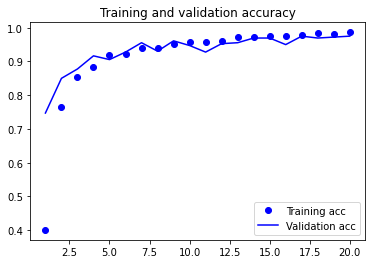

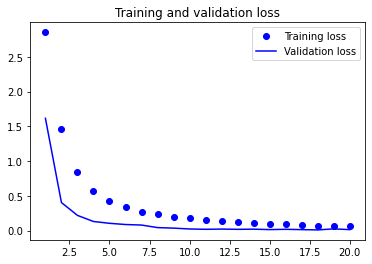

In [14]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'bo', label = 'Training acc')
plt.plot(epochs, val_acc, 'b', label = 'Validation acc')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()

plt.plot(epochs, loss, 'bo', label = 'Training loss')
plt.plot(epochs, val_loss, 'b', label = 'Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

0.975
Classification report
              precision    recall  f1-score   support

           0       0.89      0.80      0.84        10
           1       0.83      1.00      0.91        10
           2       1.00      0.80      0.89        10
           3       1.00      1.00      1.00        10
           4       1.00      1.00      1.00        10
           5       1.00      1.00      1.00        10
           6       1.00      1.00      1.00        10
           7       1.00      1.00      1.00        10
           8       1.00      0.90      0.95        10
           9       1.00      1.00      1.00        10
           A       1.00      1.00      1.00        10
           B       1.00      1.00      1.00        10
           C       1.00      1.00      1.00        10
           D       1.00      0.90      0.95        10
           E       1.00      1.00      1.00        10
           F       1.00      1.00      1.00        10
           G       1.00      1.00      1.00        10

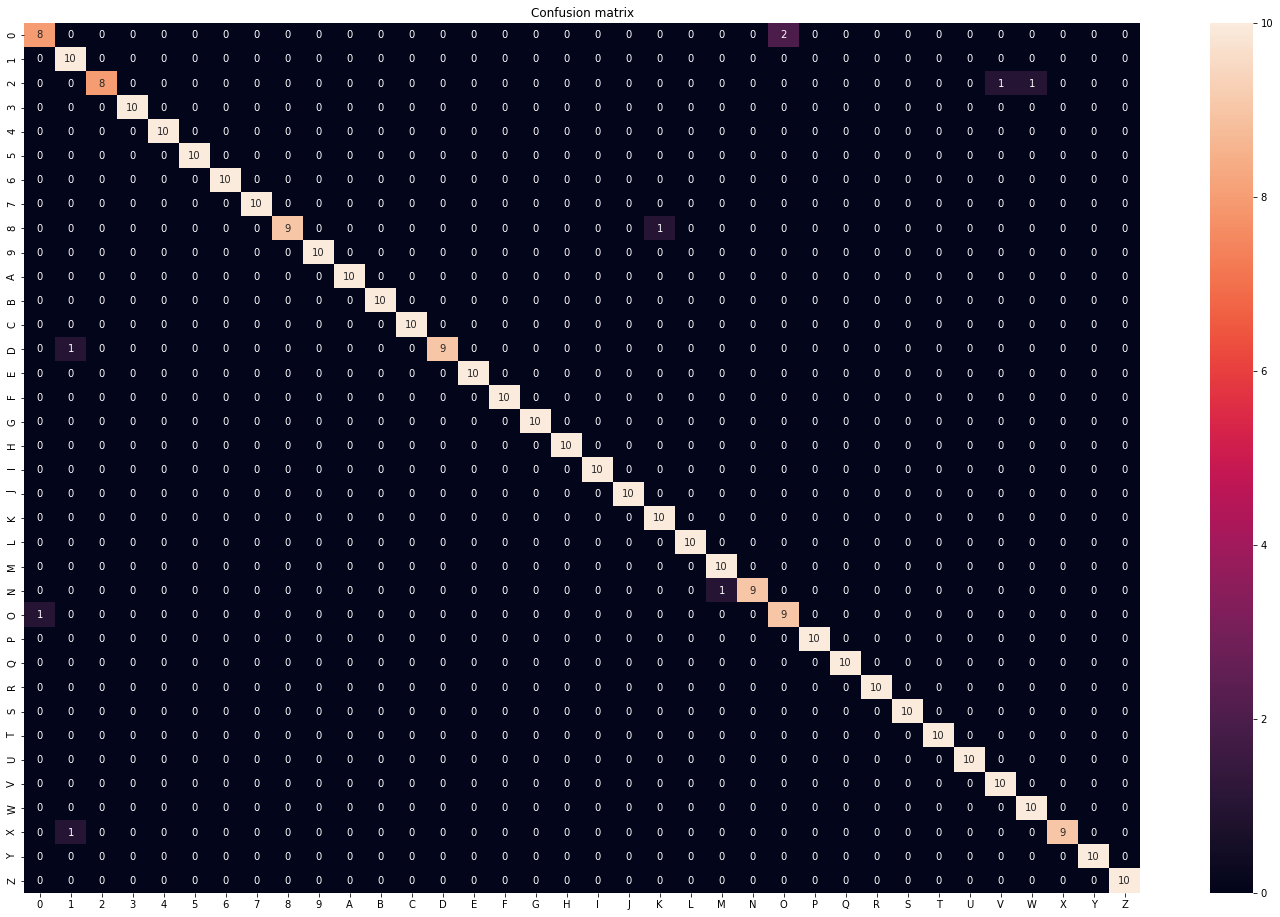

In [15]:
# results on validation data
from utils.report import report

y_pred_validation = model.predict_generator(validation_generator, num_of_validation_samples // batch_size)
y_pred_validation = np.argmax(y_pred_validation, axis=1)

report(validation_generator.classes, y_pred_validation)

0.986
Classification report
              precision    recall  f1-score   support

           0       0.92      0.79      0.85        14
           1       1.00      1.00      1.00        14
           2       1.00      0.93      0.96        14
           3       1.00      1.00      1.00        14
           4       1.00      1.00      1.00        14
           5       1.00      1.00      1.00        14
           6       1.00      0.86      0.92        14
           7       1.00      1.00      1.00        14
           8       1.00      1.00      1.00        14
           9       1.00      1.00      1.00        14
           A       1.00      1.00      1.00        14
           B       1.00      1.00      1.00        14
           C       1.00      1.00      1.00        14
           D       1.00      1.00      1.00        14
           E       1.00      1.00      1.00        14
           F       1.00      1.00      1.00        14
           G       1.00      1.00      1.00        14

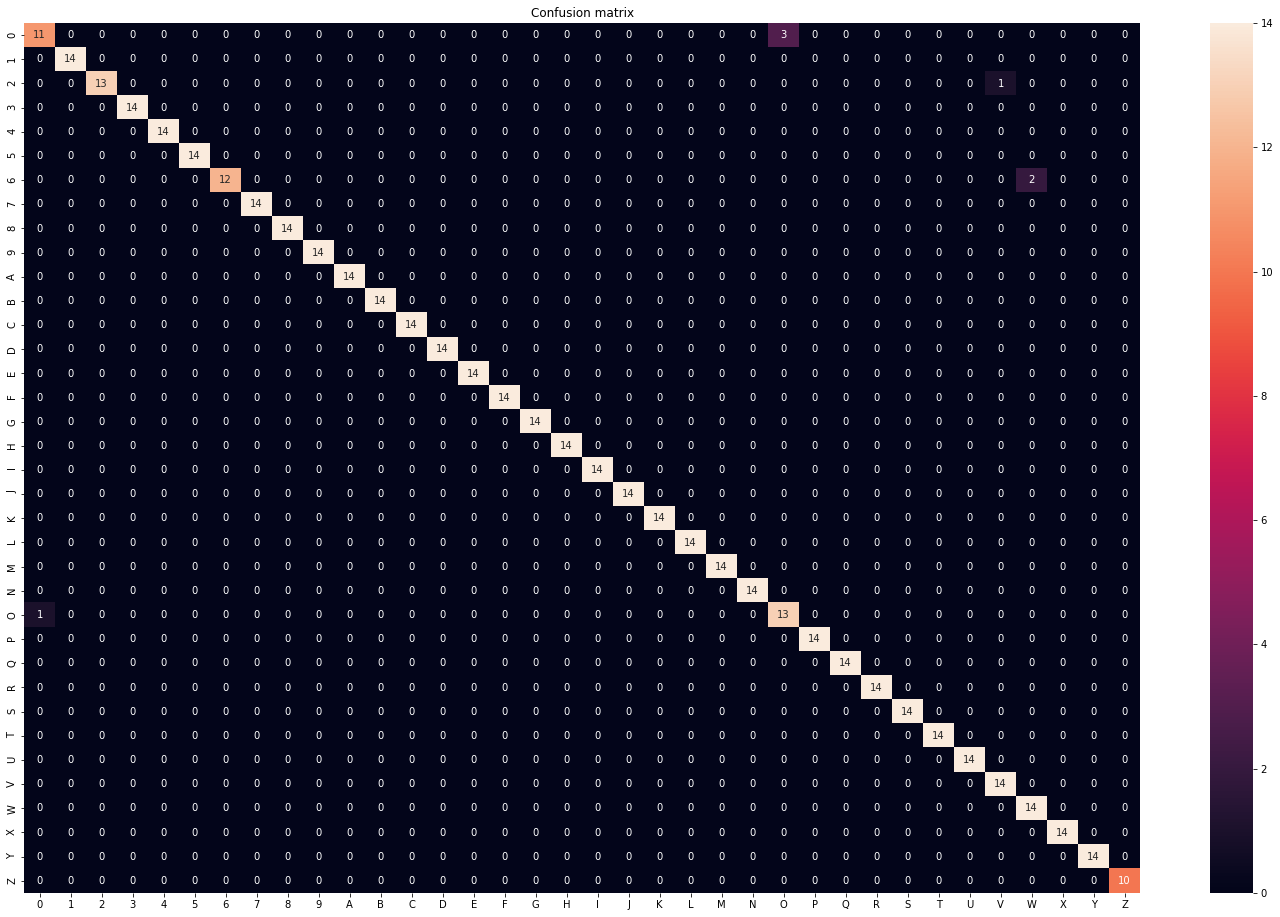

In [16]:
# results on test data
from utils.report import report

y_pred_test = model.predict_generator(test_generator, 504 // batch_size)
y_pred_test = np.argmax(y_pred_test, axis=1)

report(test_generator.classes[0:500], y_pred_test)